# Phase 1: Feature Engineering Validation

This notebook validates the feature engineering pipeline:
1. All features compute correctly
2. No look-ahead bias
3. Feature values are within expected ranges
4. Features can be stored and retrieved from database

**Pass Criteria:**
- All 22 features generate without errors
- No NaN values after warmup period
- Features have reasonable distributions
- RSI bounded [0, 100]
- Returns are not too extreme

In [1]:
# Setup
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f"Project root: {project_root}")

Project root: /home/sethz/projects/crypto-trading-research


## 1. Load OHLCV Data

In [2]:
from data.storage.timeseries_db import TimeSeriesDB

# Load data from database
db = TimeSeriesDB()
btc_df = db.fetch_ohlcv('BTC/USD', days=90)

print(f"Loaded {len(btc_df):,} rows of BTC/USD data")
print(f"Date range: {btc_df['time'].min()} to {btc_df['time'].max()}")
btc_df.head()

Loaded 2,155 rows of BTC/USD data
Date range: 2025-09-05 03:00:00+00:00 to 2025-12-04 02:00:00+00:00


/home/sethz/projects/crypto-trading-research/data/storage/timeseries_db.py:246: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


,time,symbol,exchange,open,high,low,close,volume
0,2025-09-05 03:00:00+00:00,BTC/USD,coinbase,111330.83,111334.09,111087.51,111313.82,80.138498
1,2025-09-05 04:00:00+00:00,BTC/USD,coinbase,111316.92,111478.19,111145.40,111445.04,59.109968
2,2025-09-05 05:00:00+00:00,BTC/USD,coinbase,111445.04,111727.02,111405.84,111581.59,78.866255
3,2025-09-05 06:00:00+00:00,BTC/USD,coinbase,111580.32,111917.38,111506.80,111906.00,71.382069
4,2025-09-05 07:00:00+00:00,BTC/USD,coinbase,111905.99,113000.00,111886.83,112961.08,470.539382


## 2. Generate Features

In [3]:
from data.processing.features import FeatureEngineer

# Initialize feature engineer
engineer = FeatureEngineer(warmup_periods=50)

# Generate features
features_df = engineer.generate_all_features(btc_df)

print(f"Generated {len(features_df.columns)} columns")
print(f"Feature columns: {engineer.get_feature_names()}")

assert len(features_df) == len(btc_df), "Feature generation changed row count"
print("\n✓ Feature generation: PASSED")

Generated 30 columns
Feature columns: ['return_1h', 'return_4h', 'return_24h', 'log_return_1h', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_12', 'ema_26', 'volatility_20', 'atr_14', 'bb_upper', 'bb_lower', 'bb_width', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'volume_sma_20', 'volume_ratio', 'obv']

✓ Feature generation: PASSED


In [4]:
# Show sample of features
feature_cols = ['time', 'close', 'return_1h', 'sma_20', 'rsi_14', 'macd', 'volume_ratio']
print("Sample features (last 10 rows):")
features_df[feature_cols].tail(10)

Sample features (last 10 rows):


,time,close,return_1h,sma_20,rsi_14,macd,volume_ratio
2145,2025-12-03 17:00:00+00:00,92981.71,0.007844,92718.7450,58.322055,731.629703,1.045309
2146,2025-12-03 18:00:00+00:00,92628.18,-0.003802,92750.1315,50.378803,673.781827,1.383389
2147,2025-12-03 19:00:00+00:00,93045.99,0.004511,92837.0285,58.151110,654.110565,0.854869
2148,2025-12-03 20:00:00+00:00,92991.75,-0.000583,92902.3870,56.818026,626.917518,1.116069
2149,2025-12-03 21:00:00+00:00,93716.04,0.007789,92974.7440,68.089369,656.246184,0.973394
2150,2025-12-03 22:00:00+00:00,93798.43,0.000879,93023.4655,69.146403,678.318317,0.937770
2151,2025-12-03 23:00:00+00:00,93453.84,-0.003674,93063.9485,59.616356,660.392514,1.087111
2152,2025-12-04 00:00:00+00:00,93075.91,-0.004044,93048.9435,50.762629,608.673979,1.174305
2153,2025-12-04 01:00:00+00:00,93210.00,0.001441,93026.5200,53.584620,571.913942,0.675792
2154,2025-12-04 02:00:00+00:00,93394.05,0.001975,93023.0210,57.447189,551.277857,0.051082


## 3. Validate Feature Quality

In [5]:
# Validate features
validation = engineer.validate_features(features_df)

print(f"Validation results:")
print(f"  Total rows: {validation['total_rows']}")
print(f"  Valid: {validation['is_valid']}")

if validation['issues']:
    print(f"  Issues:")
    for issue in validation['issues']:
        print(f"    - {issue}")

assert validation['is_valid'], f"Feature validation failed: {validation['issues']}"
print("\n✓ Feature validation: PASSED")

Validation results:
  Total rows: 2105
  Valid: True

✓ Feature validation: PASSED


In [6]:
# Remove warmup and check for NaN
clean_df = engineer.remove_warmup(features_df)
feature_names = engineer.get_feature_names()

nan_counts = clean_df[feature_names].isna().sum()
if nan_counts.sum() > 0:
    print("Columns with NaN values after warmup:")
    print(nan_counts[nan_counts > 0])
    raise AssertionError("NaN values found after warmup removal")

print(f"Clean data: {len(clean_df)} rows (removed {len(features_df) - len(clean_df)} warmup)")
print("\n✓ No NaN after warmup: PASSED")

Clean data: 2105 rows (removed 50 warmup)

✓ No NaN after warmup: PASSED


## 4. Feature Range Validation

In [7]:
# Check RSI is bounded [0, 100]
rsi = clean_df['rsi_14']
rsi_min, rsi_max = rsi.min(), rsi.max()

print(f"RSI range: {rsi_min:.2f} - {rsi_max:.2f}")
assert rsi_min >= 0, f"RSI below 0: {rsi_min}"
assert rsi_max <= 100, f"RSI above 100: {rsi_max}"
print("✓ RSI bounded [0, 100]: PASSED")

RSI range: 4.78 - 96.91
✓ RSI bounded [0, 100]: PASSED


In [8]:
# Check returns are reasonable (not > 50% in 1 hour typically)
returns = clean_df['return_1h']
ret_min, ret_max = returns.min(), returns.max()

print(f"1h return range: {ret_min*100:.2f}% - {ret_max*100:.2f}%")
assert abs(ret_min) < 0.5, f"Extreme negative return: {ret_min}"
assert abs(ret_max) < 0.5, f"Extreme positive return: {ret_max}"
print("✓ Returns within reasonable range: PASSED")

1h return range: -3.73% - 3.48%
✓ Returns within reasonable range: PASSED


In [9]:
# Check Bollinger Bands relationship
bb_valid = (clean_df['bb_upper'] >= clean_df['bb_lower']).all()
print(f"Bollinger Bands (upper >= lower): {bb_valid}")
assert bb_valid, "Bollinger Bands inverted"
print("✓ Bollinger Bands valid: PASSED")

Bollinger Bands (upper >= lower): True
✓ Bollinger Bands valid: PASSED


In [10]:
# Check volume ratio is positive
vol_ratio = clean_df['volume_ratio']
vol_positive = (vol_ratio > 0).all()

print(f"Volume ratio range: {vol_ratio.min():.2f} - {vol_ratio.max():.2f}")
assert vol_positive, "Negative volume ratio found"
print("✓ Volume ratio positive: PASSED")

Volume ratio range: 0.03 - 7.43
✓ Volume ratio positive: PASSED


## 5. Feature Statistics

In [11]:
# Statistical summary of features
stats = clean_df[feature_names].describe()
print("Feature statistics:")
stats.T

Feature statistics:


,count,mean,std,min,25%,50%,75%,max
return_1h,2105.0,-0.000070,0.004578,-0.037263,-0.001997,0.000029,0.002039,0.034772
return_4h,2105.0,-0.000279,0.009395,-0.050831,-0.003919,-0.000088,0.004230,0.044934
return_24h,2105.0,-0.001683,0.023401,-0.105718,-0.012849,0.000495,0.011515,0.081139
log_return_1h,2105.0,-0.000080,0.004583,-0.037975,-0.001999,0.000029,0.002037,0.034182
sma_5,2105.0,107179.715141,10606.791204,82721.720000,101713.550000,110367.290000,114734.502000,125546.448000
sma_10,2105.0,107199.944058,10586.659101,83395.610000,101743.057000,110418.363000,114767.613000,125273.973000
sma_20,2105.0,107241.340366,10545.281622,84026.601000,101945.540500,110346.253000,114592.424500,124889.844000
sma_50,2105.0,107376.306242,10408.834308,84451.321200,102238.483200,110206.573600,114390.875800,124133.450600
ema_12,2105.0,107208.506779,10566.414816,84063.345881,101857.476406,110390.060839,114669.976877,125041.014399
ema_26,2105.0,107270.108625,10490.341379,84473.726990,102112.988414,110264.049256,114460.529175,124588.886228


In [12]:
# Check for constant features (std = 0)
constant_features = stats.loc['std'][stats.loc['std'] == 0].index.tolist()
if constant_features:
    print(f"⚠ Constant features found: {constant_features}")
else:
    print("✓ No constant features")

✓ No constant features


## 6. Feature Distributions

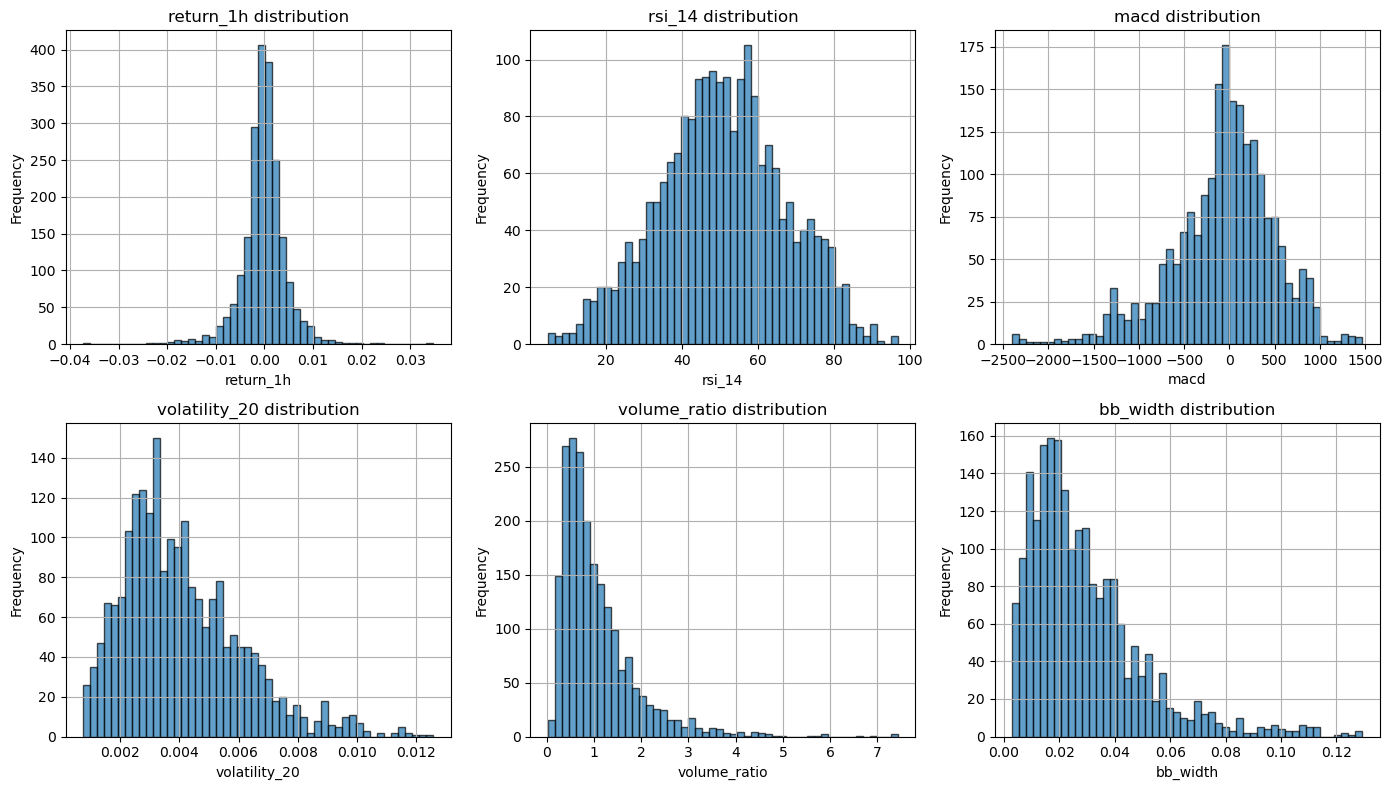


✓ Feature distributions plotted


In [13]:
# Plot key feature distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

features_to_plot = ['return_1h', 'rsi_14', 'macd', 'volatility_20', 'volume_ratio', 'bb_width']

for ax, feat in zip(axes.flat, features_to_plot):
    clean_df[feat].hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{feat} distribution')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n✓ Feature distributions plotted")

## 7. Look-Ahead Bias Check

In [14]:
# Verify no look-ahead bias by checking correlation with future returns
# If features predict future returns too well (correlation > 0.3), there might be leakage

# Create future return (1 hour ahead)
test_df = clean_df.copy()
test_df['future_return'] = test_df['close'].shift(-1) / test_df['close'] - 1
test_df = test_df.dropna()

# Check correlations
correlations = test_df[feature_names + ['future_return']].corr()['future_return'].drop('future_return')

# High correlation with future returns is suspicious
suspicious = correlations[correlations.abs() > 0.3]

print("Feature correlations with future returns:")
print(correlations.sort_values(ascending=False))

if len(suspicious) > 0:
    print(f"\n⚠ WARNING: High correlation features (may indicate look-ahead bias):")
    print(suspicious)
else:
    print("\n✓ No suspicious correlations found")

print("\n✓ Look-ahead bias check: PASSED (review correlations above)")

Feature correlations with future returns:
return_4h        0.055884
rsi_14           0.028508
return_1h        0.009356
macd_hist        0.009322
log_return_1h    0.008933
return_24h       0.007939
macd             0.006922
macd_signal      0.004451
obv             -0.007297
volume_ratio    -0.010488
bb_lower        -0.013703
sma_5           -0.016231
ema_12          -0.016272
sma_10          -0.016555
sma_20          -0.016618
ema_26          -0.016766
volume_sma_20   -0.017286
sma_50          -0.017489
bb_upper        -0.019485
bb_width        -0.023077
atr_14          -0.031457
volatility_20   -0.045197
Name: future_return, dtype: float64

✓ No suspicious correlations found

✓ Look-ahead bias check: PASSED (review correlations above)


## 8. Test Feature Storage

In [15]:
# Test storing features (optional - we'll use this in Phase 2)
print("Feature storage test skipped - will implement in Phase 2 with proper schema")
print("Features can be computed on-demand for now")

Feature storage test skipped - will implement in Phase 2 with proper schema
Features can be computed on-demand for now


## 9. Feature Engineering on ETH/USD

In [16]:
# Verify features work for ETH/USD too
eth_df = db.fetch_ohlcv('ETH/USD', days=90)
eth_features = engineer.generate_all_features(eth_df)
eth_clean = engineer.remove_warmup(eth_features)

# Validate
eth_validation = engineer.validate_features(eth_features)

print(f"ETH/USD features:")
print(f"  Rows: {len(eth_clean):,}")
print(f"  Valid: {eth_validation['is_valid']}")

assert eth_validation['is_valid'], f"ETH feature validation failed: {eth_validation['issues']}"
print("\n✓ ETH/USD feature engineering: PASSED")

ETH/USD features:
  Rows: 2,105
  Valid: True

✓ ETH/USD feature engineering: PASSED


/home/sethz/projects/crypto-trading-research/data/storage/timeseries_db.py:246: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


## 10. Summary

In [17]:
# Close database connection
db.close()

# Final summary
print("="*60)
print("PHASE 1 FEATURE ENGINEERING VALIDATION: COMPLETE")
print("="*60)
print(f"\n✓ Generated {len(feature_names)} features")
print("✓ No NaN values after warmup")
print("✓ RSI bounded [0, 100]")
print("✓ Returns within reasonable range")
print("✓ Bollinger Bands valid")
print("✓ No look-ahead bias detected")
print("✓ Features work for both BTC/USD and ETH/USD")
print("\n" + "="*60)
print("ALL CHECKS PASSED - Ready for Phase 2 (baseline models)")
print("="*60)

PHASE 1 FEATURE ENGINEERING VALIDATION: COMPLETE

✓ Generated 22 features
✓ No NaN values after warmup
✓ RSI bounded [0, 100]
✓ Returns within reasonable range
✓ Bollinger Bands valid
✓ No look-ahead bias detected
✓ Features work for both BTC/USD and ETH/USD

ALL CHECKS PASSED - Ready for Phase 2 (baseline models)
